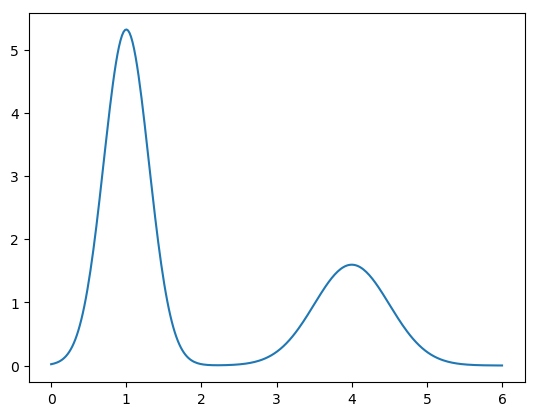

In [27]:
using PyCall
include("../src/gauss_error.jl")
include("../src/kernels.jl")

a = 0.
b = 6.

function phi(x::Real)
    mu1 = 1.
    mu2 = 4.
    n1 = 4.
    n2 = 2.
    sig1 = 0.3
    sig2 = 0.5

    norm(n, mu, sig, x) = n / sqrt(2 * pi*sig^2) * exp(-(x - mu)^2 / (2 * sig^2))
    return norm(n1, mu1, sig1, x) + norm(n2, mu2, sig2, x)
end

# function phi(x::Real)
#     return cos(x)
# end

x = collect(range(a, stop=b, length=300))

import PyPlot.plot
myplot = plot(x, phi.(x))
savefig("function.png", dpi=1000)

In [28]:
function kernel(x::Real, y::Real)
    return getOpticsKernels("gaussian")(x, y)
end

kernel (generic function with 1 method)

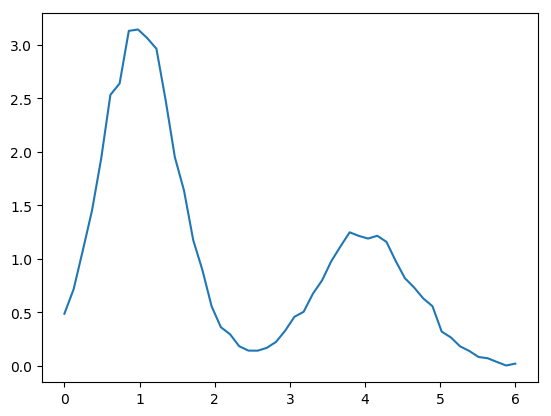

In [29]:
convolution = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, maxevals=10^7)[1]
y = collect(range(a, stop = b, length=50))
ftrue = convolution.(y)
sig = 0.05*abs.(ftrue) +[0.01 for i = 1:Base.length(ftrue)]
using Compat, Random, Distributions
noise = []
for sigma in sig
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise, n)
end
f = ftrue + noise
# f = [0.0250447, 0.0259323, 0.0300055, 0.0697762, 0.106568, 0.199481, 0.286887, 0.448353, 0.564742, 0.793431, 1.18831, 1.41718, 1.73265, 2.2737, 2.37566, 2.64492, 2.82908, 2.52841, 2.51898, 2.64624, 2.22185, 1.75508, 1.48881, 1.2669, 1.09605, 0.953436, 0.859025, 0.994736, 0.938362, 1.04007, 1.11036, 1.17168, 1.2502, 1.15296, 1.20842, 1.05919, 1.0105, 0.859411, 0.714523, 0.612392, 0.508907, 0.396421, 0.264456, 0.205983, 0.125906, 0.0530743, 0.0718868, 0.0308666, 0.0121104, 0.0207568]
plot(y, f)
savefig("integrated_function.png", dpi=1000)

In [ ]:
basis = CubicSplineBasis(y, "dirichlet")
for basis_function in basis.basis_functions
    plot(x, basis_function.f.(x))
end
savefig("basis.png", dpi=1000)

In [ ]:
# @time discretize_kernel(basis, kernel, y)

Kmn = discretize_kernel(basis, kernel, y)

In [ ]:
model = GaussErrorMatrixUnfolder([omega(basis, 2)], "EmpiricalBayes", nothing, [1e-5], [1.], [0.5])

In [ ]:
result = solve(model, Kmn, f, sig)

In [ ]:
phivec = PhiVec(result, basis)

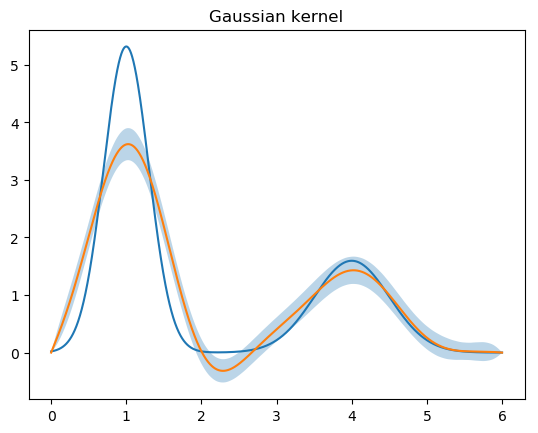

PyObject Text(0.5, 1.0, 'Gaussian kernel')

In [22]:
x = collect(range(a, stop=b, length=5000))
plot(x, phi.(x))

phi_reconstructed = phivec.phi_function.(x)
phi_reconstructed_errors = phivec.error_function.(x)

plot(x, phi_reconstructed)
fill_between(x, phi_reconstructed - phi_reconstructed_errors, phi_reconstructed + phi_reconstructed_errors, alpha=0.3)

In [23]:
print(f)

[0.474883, 0.767126, 1.03632, 1.48406, 1.70031, 2.21218, 2.66268, 3.01602, 2.89652, 3.04867, 2.78505, 2.58828, 2.0926, 1.56803, 1.23357, 0.857967, 0.554728, 0.350218, 0.277941, 0.155043, 0.170613, 0.149528, 0.190932, 0.289772, 0.334137, 0.464774, 0.594206, 0.687337, 0.898117, 0.866339, 0.968813, 1.22067, 1.34893, 1.08883, 1.20326, 1.04745, 1.06202, 0.859395, 0.736013, 0.557161, 0.492976, 0.35631, 0.277228, 0.218846, 0.170579, 0.0882846, 0.0655168, 0.0488727, 0.0299589, 0.0222046]

In [24]:
print(result["errors"])

[0.00485687 0.0105181 0.0114616 0.00844424 0.00404279 -8.75003e-5 -0.00306687 -0.00460969 -0.0048348 -0.00408982 -0.00280538 -0.00138745 -0.000149359 0.000719547 0.00115482 0.00119555 0.00094957 0.000554263 0.000140975 -0.00019096 -0.000387345 -0.00043934 -0.000373569 -0.000236653 -7.91052e-5 5.74421e-5 0.000147466 0.000183006 0.00017059 0.000125684 6.66922e-5 1.00333e-5 -3.29016e-5 -5.68108e-5 -6.19232e-5 -5.24203e-5 -3.44645e-5 -1.43517e-5 2.87224e-6 1.41705e-5 1.86562e-5 1.72346e-5 1.19412e-5 5.18527e-6 -9.1058e-7 -4.94669e-6 -6.40278e-6 -5.53645e-6 -3.1015e-6 -1.03027e-6; 0.0105181 0.03353 0.0340204 0.0256418 0.0122645 -0.00010559 -0.00909674 -0.0137676 -0.0144859 -0.012283 -0.00844938 -0.0042027 -0.000485337 0.0021311 0.00344942 0.00358351 0.00285453 0.00167355 0.000434649 -0.000563276 -0.00115629 -0.0013165 -0.0011227 -0.00071412 -0.000242146 0.000168081 0.000439534 0.000547807 0.00051205 0.000378377 0.000201893 3.18988e-5 -9.72889e-5 -0.000169583 -0.000185499 -0.000157454 -0.000

-0.000233767 -7.80793e-5; 0.000140975 0.000434649 0.00138429 0.00289404 0.00462975 0.00596914 0.00615452 0.00449147 0.000572421 -0.00550639 -0.0129779 -0.0203424 -0.0254713 -0.025947 -0.0196384 -0.00569168 0.0147806 0.0359388 0.051868 0.0341063 0.0118764 -0.00840733 -0.0208307 -0.0246408 -0.0213458 -0.0138014 -0.00499421 0.00268059 0.007793 0.00990723 0.00938135 0.00705315 0.00391717 0.00086478 -0.00147754 -0.00280778 -0.00312379 -0.0026434 -0.00170022 -0.000642155 0.00024801 0.000799476 0.000965782 0.000807673 0.000456093 6.67473e-5 -0.000223123 -0.000327965 -0.00023321 -7.83113e-5; -0.00019096 -0.000563276 -0.000460671 0.000566443 0.00240535 0.00460448 0.00645938 0.00715009 0.0059247 0.00231435 -0.00364773 -0.0112459 -0.0190007 -0.0247526 -0.0259959 -0.0204632 -0.0071475 0.0129676 0.0341063 0.0503305 0.0330733 0.0114041 -0.00841513 -0.020575 -0.0243532 -0.0212151 -0.0139253 -0.00536803 0.00214164 0.00721206 0.00940231 0.00903406 0.00689595 0.00393766 0.0010206 -0.00124107 -0.00254326

-3.44645e-5 -0.000103867 -0.000205587 -0.000286153 -0.000317009 -0.000267755 -0.000116038 0.000142122 0.00048362 0.000853663 0.00116785 0.00132313 0.0012187 0.000785396 1.90758e-5 -0.000990652 -0.00204803 -0.00286707 -0.00312379 -0.00254326 -0.00100691 0.00134819 0.00407432 0.00643744 0.00754113 0.00654601 0.00294992 -0.00313328 -0.0107755 -0.0181986 -0.0229644 -0.0224383 -0.0144775 0.00152465 0.0239921 0.0465406 0.0628158 0.0441894 0.020068 -0.00264946 -0.0174306 -0.0229913 -0.0205855 -0.013176 -0.00416871 0.00347266 0.00781616 0.00818896 0.00510625 0.00170489; -1.43517e-5 -4.36165e-5 -0.000105797 -0.00018317 -0.000255766 -0.000292479 -0.000259416 -0.000130026 0.000104353 0.000425474 0.000783099 0.00109649 0.00126486 0.00118796 0.000795462 8.04878e-5 -0.000871772 -0.00187203 -0.0026434 -0.0028736 -0.00230049 -0.000815631 0.00144192 0.00403597 0.00625971 0.00725601 0.00622626 0.00269513 -0.00322617 -0.0106508 -0.0178783 -0.0225676 -0.0221743 -0.0146065 0.000756966 0.0224308 0.0441894 0

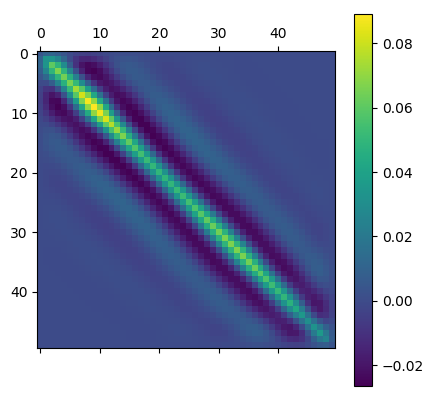

PyObject <matplotlib.colorbar.Colorbar object at 0x19510bfd0>

In [25]:
matshow(result["errors"])
colorbar()

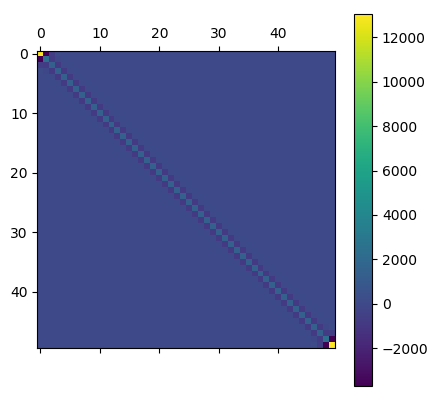

PyObject <matplotlib.colorbar.Colorbar object at 0x1af044eb8>

In [26]:
matshow(omega(basis, 2))
colorbar()